In [25]:
import pandas as pd
from bettools import get_data, generate_seasons, calculate_poisson_match_outcomes, calculate_ev_from_odds
import matplotlib.pyplot as plt

In [26]:
leagues = ['E0']

season_list = generate_seasons(2023, 2024)

df_ls = get_data(season_list, leagues)

In [27]:
main_df = pd.concat(df_ls)

In [28]:
main_df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,PSH,PSD,PSA,home_max_odds,away_max_odds,draw_max_odds
0,E0,2023-08-11,Burnley,Man City,0,3,8.58,5.51,1.37,9.50,1.37,5.51
1,E0,2023-08-12,Arsenal,Nott'm Forest,2,1,1.18,7.86,15.67,1.20,17.00,7.86
2,E0,2023-08-12,Bournemouth,West Ham,1,1,2.70,3.47,2.71,2.70,2.71,3.47
3,E0,2023-08-12,Brighton,Luton,4,1,1.33,5.65,9.61,1.35,10.00,5.65
4,E0,2023-08-12,Everton,Fulham,0,1,2.27,3.45,3.35,2.27,3.35,3.45


In [29]:
def create_league_table(matches_df):
    # Initialize a dictionary to store statistics for each team
    league_table = {}
    
    for index, match in matches_df.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        home_goals = match['FTHG']
        away_goals = match['FTAG']
        
        # Initialize teams in the league table if not already present
        if home_team not in league_table:
            league_table[home_team] = {'Played': 0, 'Won': 0, 'Drawn': 0, 'Lost': 0,
                                       'Goals For': 0, 'Goals Against': 0, 'Goal Difference': 0, 'Points': 0}
        if away_team not in league_table:
            league_table[away_team] = {'Played': 0, 'Won': 0, 'Drawn': 0, 'Lost': 0,
                                       'Goals For': 0, 'Goals Against': 0, 'Goal Difference': 0, 'Points': 0}
        
        # Update statistics for the home team
        league_table[home_team]['Played'] += 1
        league_table[home_team]['Goals For'] += home_goals
        league_table[home_team]['Goals Against'] += away_goals
        league_table[home_team]['Goal Difference'] += (home_goals - away_goals)
        
        # Update statistics for the away team
        league_table[away_team]['Played'] += 1
        league_table[away_team]['Goals For'] += away_goals
        league_table[away_team]['Goals Against'] += home_goals
        league_table[away_team]['Goal Difference'] += (away_goals - home_goals)
        
        # Determine the result and update points
        if home_goals > away_goals:
            league_table[home_team]['Won'] += 1
            league_table[home_team]['Points'] += 3
            league_table[away_team]['Lost'] += 1
        elif home_goals < away_goals:
            league_table[away_team]['Won'] += 1
            league_table[away_team]['Points'] += 3
            league_table[home_team]['Lost'] += 1
        else:
            league_table[home_team]['Drawn'] += 1
            league_table[away_team]['Drawn'] += 1
            league_table[home_team]['Points'] += 1
            league_table[away_team]['Points'] += 1
    
    # Convert the dictionary to a DataFrame
    league_df = pd.DataFrame.from_dict(league_table, orient='index')
    
    # Sort the DataFrame by Points, Goal Difference, and Goals For
    league_df = league_df.sort_values(by=['Points', 'Goal Difference', 'Goals For'], ascending=False)
    
    return league_df

In [31]:
league_df = create_league_table(main_df)

league_df

,Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points
Man City,38,28,7,3,96,34,62,91
Arsenal,38,28,5,5,91,29,62,89
Liverpool,38,24,10,4,86,41,45,82
Aston Villa,38,20,8,10,76,61,15,68
Tottenham,38,20,6,12,74,61,13,66
Chelsea,38,18,9,11,77,63,14,63
Newcastle,38,18,6,14,85,62,23,60
Man United,38,18,6,14,57,58,-1,60
West Ham,38,14,10,14,60,74,-14,52
Crystal Palace,38,13,10,15,57,58,-1,49


In [32]:
def pythag_expected_points(goals_for, goals_against, games_played, a, b, c, d):
    pythag_frac = (goals_for**b) / (goals_for**c + goals_against**d)
    
    return a * pythag_frac * games_played

pythag_expected_points(96, 34, 38, 2.78, 1.24, 1.24, 1.25)

82.14760798376412

In [38]:
a = 2.78
b = 1.24
c = 1.24
d = 1.25

league_df['Expected Points'] = league_df.apply(
        lambda row: pythag_expected_points(row['Goals For'], row['Goals Against'], row['Played'], a, b, c, d), axis=1)

league_df

,Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points,Expected Points
Man City,38,28,7,3,96,34,62,91,82.147608
Arsenal,38,28,5,5,91,29,62,89,84.479049
Liverpool,38,24,10,4,86,41,45,82,74.699898
Aston Villa,38,20,8,10,76,61,15,68,58.907199
Tottenham,38,20,6,12,74,61,13,66,58.043889
Chelsea,38,18,9,11,77,63,14,63,58.277892
Newcastle,38,18,6,14,85,62,23,60,61.969502
Man United,38,18,6,14,57,58,-1,60,51.178614
West Ham,38,14,10,14,60,74,-14,52,44.876007
Crystal Palace,38,13,10,15,57,58,-1,49,51.178614


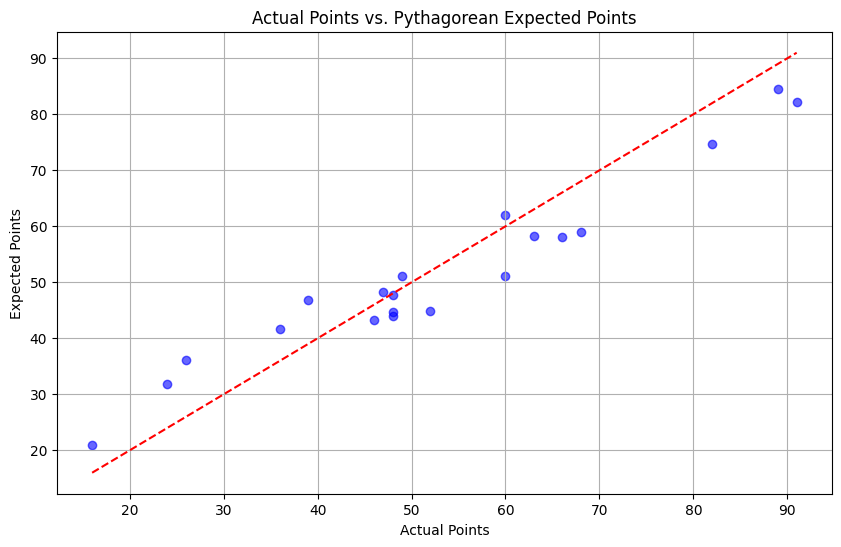

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(league_df['Points'], league_df['Expected Points'], color='blue', alpha=0.6)
plt.plot([league_df['Points'].min(), league_df['Points'].max()],
         [league_df['Points'].min(), league_df['Points'].max()], color='red', linestyle='--')
plt.title('Actual Points vs. Pythagorean Expected Points')
plt.xlabel('Actual Points')
plt.ylabel('Expected Points')
plt.grid(True)
plt.show()

In [41]:
from IPython.display import display, Math

# Display the adapted Pythagorean expectation formula
display(Math(r"\text{Expected Points} = a \times \left( \frac{\text{Goals For}^b}{\text{Goals For}^c + \text{Goals Against}^d} \right) \times \text{Games Played}"))

<IPython.core.display.Math object>

In [43]:
# Display the Pythagorean expectation formula for baseball
display(Math(r"\text{Expected Win Percentage} = \frac{\text{RS}^{1.83}}{\text{RS}^{1.83} + \text{RA}^{1.83}}"))

# Display the formula for expected wins
display(Math(r"\text{Expected Wins} = \text{Expected Win Percentage} \times \text{Games Played}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>